In [1]:
import typing as tp
import tempfile
from copy import deepcopy

# Bare openbabel import is needed in order to import pybel
import torch
import openbabel  # noqa
from openbabel import pybel
import ase.io
from rdkit import Chem
import numpy as np
from numpy.typing import NDArray
import torchani
from torchani.neighbors import FullPairwise
from torchani.datasets import ANIDataset
import pandas as pd
import ase
import nglview as nv

In [2]:
def arrays_to_rdkit_molecule(
    symbols: NDArray[np.str_],
    coords: NDArray[np.float64],
    verbose: bool = True,
) -> Chem.rdchem.Mol:
    with tempfile.NamedTemporaryFile("w+") as f:
        f.write(f"{len(symbols)}\n")
        f.write("\n")
        for j, el in enumerate(symbols):
            f.write(f"{el} {coords[j][0]:8.3} {coords[j][1]:8.3} {coords[j][2]:8.3}\n")
        f.seek(0)
        obabel_molecule = next(pybel.readfile("xyz", f.name))
        raw_mol2 = obabel_molecule.write(format="mol2")
        molecule = Chem.MolFromMol2Block(raw_mol2, removeHs=False)
        if molecule is None:
            raise RuntimeError("Molecule could not be generated by rdkit")
        if verbose:
            print("SMILES: ", Chem.MolToSmiles(molecule))
    return molecule


In [3]:
anidr = torchani.models.ANIdr().double()

In [21]:
ds = ANIDataset('/home/nick/First_DSs/ANI-1x-first-conformers.h5')
mol = (ds['C2H3N7O2']['species'].numpy().squeeze(), ds['C2H3N7O2']['coordinates'].detach().numpy().squeeze())

In [22]:
test_mol = ase.Atoms(numbers=mol[0], positions=mol[1])
test_species_coord = (torch.tensor(test_mol.numbers).unsqueeze(0), torch.tensor(test_mol.positions, requires_grad=True).unsqueeze(0))

relative_stdev = anidr.force_qbc(test_species_coord).relative_stdev
#relative_stdev = [1 if i > 0.5 else 0 for i in relative_stdev.squeeze()]
highlight_indices = [i for i, val in enumerate(relative_stdev.squeeze()) if val > 0.5]
print(highlight_indices)

viewer2 = nv.show_ase(test_mol)
viewer2.add_representation('ball+stick', selection=highlight_indices, color='purple', radius=0.4) # You can adjust the radius as per your need
viewer2.display()

[2, 11]


NGLWidget()

In [20]:
mol_tensor = (ds['CH2N4O2']['species'], ds['CH2N4O2']['coordinates'].double())
force_qbc = anidr.force_qbc(mol_tensor)
print(force_qbc.relative_stdev)

tensor([[0.0278, 0.0126, 0.0056, 0.0689, 0.0379, 0.0357, 0.0127, 0.0124, 0.0412]],
       dtype=torch.float64)


In [7]:
# Define test system here -- note that i'm highlighting stdev > 0.5 (not 1, 1.5, etc.)

test_species_coord = (torch.tensor(test_mol.numbers).unsqueeze(0), torch.tensor(test_mol.positions, requires_grad=True).unsqueeze(0))
species, _, relative_stdev, _ = anidr.force_qbc(test_species_coord)
relative_stdev = [1 if i > 0.5 else 0 for i in relative_stdev.squeeze()]
coord = test_species_coord[1]
print(list(test_mol.numbers))
print(relative_stdev)

[6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 6, 6, 1, 1, 6, 6, 6, 1, 1, 7, 1, 1, 6, 1, 8, 1, 8, 1, 7]
[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [8]:
capper_input = (test_mol.numbers, test_mol.positions, relative_stdev)
#print(capper_input)

SMILES:  [H][C]1C([H])=C(C([H])([H])C#CC([H])([H])[C@@]([H])(C([H])=O)N([H])[H])C([H])=C([C]=[N-])[C@]1([H])[C][O-]


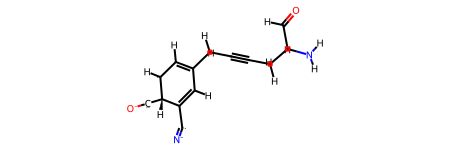

In [9]:
molecule = arrays_to_rdkit_molecule(capper_input[0], capper_input[1])
molecule

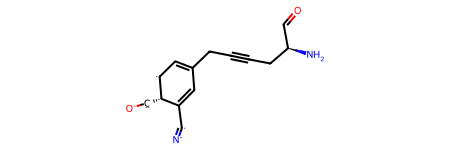

In [10]:
mol = Chem.RemoveHs(molecule)
mol

In [11]:
bad_atom_indices = capper_input[2]
out = FullPairwise(cutoff=5.2)(torch.tensor(capper_input[0]).unsqueeze(0), torch.tensor(capper_input[1]).unsqueeze(0))
neighbor_indices = torch.cat((out.indices, out.indices.flip(0)), dim=-1).transpose(1, 0)
_expanded_bad_atom_indices: tp.Set[int] = set()
for b in bad_atom_indices:
    idxs = neighbor_indices[neighbor_indices[:, 0] == b, 1]
    _expanded_bad_atom_indices.update(idxs.tolist())
print(_expanded_bad_atom_indices)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 27, 28, 29}


In [12]:
import torch
import typing as tp
from copy import deepcopy
import ase.io
from rdkit import Chem

def process_bad_atom(capper_input, bad_atom_index):
    molecule = arrays_to_rdkit_molecule(symbols=capper_input[0], coords=capper_input[1])

    out = FullPairwise(cutoff=5.2)(
        torch.tensor(capper_input[0]).unsqueeze(0), torch.tensor(capper_input[1]).unsqueeze(0)
    )
    neighbor_indices = torch.cat((out.indices, out.indices.flip(0)), dim=-1).transpose(1, 0)

    _expanded_bad_atom_indices: tp.Set[int] = set()
    idxs = neighbor_indices[neighbor_indices[:, 0] == bad_atom_index, 1]
    _expanded_bad_atom_indices.update(idxs.tolist())

    bad_atom_indices = sorted(_expanded_bad_atom_indices)

    internal_bad_atom_indices: tp.List[int] = []
    leaf_bad_atom_indices: tp.List[int] = []

    atom_list = list(molecule.GetAtoms())
    for idx in bad_atom_indices:
        atom = atom_list[idx]
        bonds = atom.GetBonds()
        for bond in bonds:
            begin = bond.GetBeginAtomIdx()
            if begin not in bad_atom_indices:
                leaf_bad_atom_indices.append(idx)
                break
        else:
            internal_bad_atom_indices.append(idx)

    capped_indices = deepcopy(bad_atom_indices)

    for idx in leaf_bad_atom_indices:
        atom = atom_list[idx]
        bonds = atom.GetBonds()
        for bond in bonds:
            begin = bond.GetBeginAtomIdx()
            if begin not in bad_atom_indices:
                bond_type = bond.GetBondType()
                if bond_type is not Chem.rdchem.BondType.SINGLE:
                    raise NotImplementedError("Not implemented yet")
                else:
                    symbols[begin] = "H"
                    capped_indices.append(begin)

    capped_coords = capper_input[1][capped_indices]
    capped_symbols = capper_input[0][capped_indices]

    capped_structure = ase.Atoms(positions=capped_coords, symbols=capped_symbols)
    ase.io.write(f"/home/nick/test_capped_{bad_atom_index}.xyz", capped_structure)

# Calling the function for each "bad atom"
symbols = capper_input[0]
for bad_atom in capper_input[2]:
    process_bad_atom(capper_input, bad_atom)


SMILES:  [H][C]1C([H])=C(C([H])([H])C#CC([H])([H])[C@@]([H])(C([H])=O)N([H])[H])C([H])=C([C]=[N-])[C@]1([H])[C][O-]


ValueError: invalid literal for int() with base 10: 'H'

In [13]:
# Ignacio's code that has been implemented into the loop above:

molecule = arrays_to_rdkit_molecule(symbols=capper_input[0], coords=capper_input[1])

bad_atom_indices: tp.List[int] = capper_input[2]
# Here you put the cutoff that you want
# The indices are expanded to include everything
# inside the AEVs
out = FullPairwise(cutoff=5.2)(
    torch.tensor(capper_input[0]).unsqueeze(0), torch.tensor(capper_input[1]).unsqueeze(0)
)
neighbor_indices = torch.cat((out.indices, out.indices.flip(0)), dim=-1).transpose(1, 0)
_expanded_bad_atom_indices: tp.Set[int] = set()

for b in bad_atom_indices:
    idxs = neighbor_indices[neighbor_indices[:, 0] == b, 1]
    _expanded_bad_atom_indices.update(idxs.tolist())

bad_atom_indices = sorted(_expanded_bad_atom_indices)

# Internal are bad atoms that are only bonded to other bad atoms
internal_bad_atom_indices: tp.List[int] = []
# Leaves are bad atoms that are bonded to one or more non-bad atoms
leaf_bad_atom_indices: tp.List[int] = []


# We need to go ver all the atoms and check which are leaves and which are core.
atom_list = list(molecule.GetAtoms())
for idx in bad_atom_indices:
    atom = atom_list[idx]
    bonds = atom.GetBonds()
    for bond in bonds:
        begin = bond.GetBeginAtomIdx()  # end is self, begin is other
        if begin not in bad_atom_indices:
            leaf_bad_atom_indices.append(idx)
            break
    else:
        internal_bad_atom_indices.append(idx)



capped_indices = deepcopy(bad_atom_indices)

for idx in leaf_bad_atom_indices:
    atom = atom_list[idx]
    bonds = atom.GetBonds()
    for bond in bonds:
        begin = bond.GetBeginAtomIdx()
        if begin not in bad_atom_indices:
            bond_type = bond.GetBondType()
            if bond_type is not Chem.rdchem.BondType.SINGLE:
                # Do some work here, there may be things that need to be done
                raise NotImplementedError("Not implemented yet")
            else:
                symbols[begin] = "H"
                capped_indices.append(begin)

capped_coords = capper_input[1][capped_indices]
capped_symbols = capper_input[0][capped_indices]

capped_structure = ase.Atoms(positions=capped_coords, symbols=capped_symbols)
ase.io.write("/home/nick/test_capped.xyz", capped_structure)          #NOTE: This function can infer file type by the extension, or it can be manually set with format='xyz'/'pdb'/etc


SMILES:  [H][C]1C([H])=C(C([H])([H])C#CC([H])([H])[C@@]([H])(C([H])=O)N([H])[H])C([H])=C([C]=[N-])[C@]1([H])[C][O-]


In [14]:
capped_test_mol = ase.io.read('/home/nick/test_capped.xyz')
viewer2 = nv.show_ase(capped_test_mol)
viewer2.display()

NGLWidget()

In [80]:
df = pd.read_pickle('/home/nick/Isolate_atoms/1x_first_output_dict.pkl')
df

,species,coordinates,relative_range,relative_stdev
C10H10,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-2.0473, device='cuda:0', grad_fn=<U...","[tensor(0.0250, device='cuda:0'), tensor(0.053...","[tensor(0.0731, device='cuda:0'), tensor(0.149..."
C10H10N2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.5131, device='cuda:0', grad_fn=<Un...","[tensor(0.0534, device='cuda:0'), tensor(0.204...","[tensor(0.1691, device='cuda:0'), tensor(0.546..."
C10H10N2O,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-1.5451, device='cuda:0', grad_fn=<U...","[tensor(0.0067, device='cuda:0'), tensor(0.099...","[tensor(0.0205, device='cuda:0'), tensor(0.261..."
C10H10N2O2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.8615, device='cuda:0', grad_fn=<Un...","[tensor(0.0218, device='cuda:0'), tensor(0.048...","[tensor(0.0730, device='cuda:0'), tensor(0.129..."
C10H10N4,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-4.4255, device='cuda:0', grad_fn=<U...","[tensor(0.0068, device='cuda:0'), tensor(0.117...","[tensor(0.0179, device='cuda:0'), tensor(0.341..."
...,...,...,...,...
N2O3,"[[tensor(7, device='cuda:0'), tensor(7, device...","[[[tensor(1.9549, device='cuda:0', grad_fn=<Un...","[tensor(0.0616, device='cuda:0'), tensor(0.060...","[tensor(0.1819, device='cuda:0'), tensor(0.168..."
N4,"[[tensor(7, device='cuda:0'), tensor(7, device...","[[[tensor(-1.6884, device='cuda:0', grad_fn=<U...","[tensor(0.5350, device='cuda:0'), tensor(0.551...","[tensor(1.4507, device='cuda:0'), tensor(1.496..."
O2,"[[tensor(8, device='cuda:0'), tensor(8, device...","[[[tensor(0., device='cuda:0', grad_fn=<Unbind...","[tensor(0.0412, device='cuda:0'), tensor(0.041...","[tensor(0.1043, device='cuda:0'), tensor(0.104..."
O3,"[[tensor(8, device='cuda:0'), tensor(8, device...","[[[tensor(1.0043, device='cuda:0', grad_fn=<Un...","[tensor(0.0037, device='cuda:0'), tensor(0.005...","[tensor(0.0109, device='cuda:0'), tensor(0.013..."


In [81]:
df['relative_stdev'] = df['relative_stdev'].apply(lambda x: [float(val) for val in x])
df['relative_range'] = df['relative_range'].apply(lambda x: [float(val) for val in x])

In [82]:
condition = df['relative_stdev'].apply(lambda x: any(val > 1.5 for val in x))
len(df[condition])

127

In [83]:
filtered_df = df[condition]
filtered_df

,species,coordinates,relative_range,relative_stdev
C10H22N2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.8079, device='cuda:0', grad_fn=<Un...","[0.2812778949737549, 0.47908252477645874, 0.17...","[0.7114307284355164, 1.5271075963974, 0.575314..."
C10H3NO,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-0.9084, device='cuda:0', grad_fn=<U...","[0.24389329552650452, 0.134811669588089, 0.040...","[0.6099414229393005, 0.3811359107494354, 0.114..."
C10H5N,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-6.3169, device='cuda:0', grad_fn=<U...","[0.021898603066802025, 0.1862783133983612, 0.2...","[0.0637490525841713, 0.4981892704963684, 0.645..."
C11H14,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.3402, device='cuda:0', grad_fn=<Un...","[0.05369645729660988, 0.1478632092475891, 0.14...","[0.15190637111663818, 0.45419391989707947, 0.3..."
C11H17N3O6,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.5624, device='cuda:0', grad_fn=<Un...","[0.05875224247574806, 0.5297955870628357, 0.03...","[0.16213743388652802, 1.5366764068603516, 0.09..."
...,...,...,...,...
CH4O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(-1.7581, device='cuda:0', grad_fn=<U...","[0.08544192463159561, 0.08824586123228073, 0.1...","[0.23528477549552917, 0.23359857499599457, 0.3..."
CH5N5O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.2798, device='cuda:0', grad_fn=<Un...","[0.32158032059669495, 0.5602786540985107, 0.33...","[0.8986567258834839, 1.6935776472091675, 1.037..."
CH7N5O2,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.8830, device='cuda:0', grad_fn=<Un...","[0.08764337003231049, 0.3693331778049469, 0.11...","[0.2494133561849594, 1.0652952194213867, 0.265..."
HN3O2,"[[tensor(1, device='cuda:0'), tensor(7, device...","[[[tensor(1.6709, device='cuda:0', grad_fn=<Un...","[0.08424440771341324, 0.0760398581624031, 0.52...","[0.25793373584747314, 0.19284576177597046, 1.6..."


In [84]:
# Explode the 'species' column
exploded_species = filtered_df['species'].explode().explode().reset_index(drop=True)


# Repeat the other columns to match the length of the exploded 'species' and 'coordinates' columns
other_columns = ['relative_range', 'relative_stdev']
exploded_other_columns = pd.concat([filtered_df[col].explode().reset_index(drop=True) for col in other_columns], axis=1)

# Create the final exploded DataFrame
exploded_df = pd.concat([exploded_species, exploded_other_columns], axis=1)

In [85]:
exploded_df['species'] = exploded_df['species'].apply(lambda x: x.tolist())


In [86]:
exploded_df

,species,relative_range,relative_stdev
0,6,0.281278,0.711431
1,6,0.479083,1.527108
2,6,0.179138,0.575315
3,6,0.260172,0.7425
4,6,0.378401,0.981745
...,...,...,...
2635,8,0.15639,0.392257
2636,7,0.535015,1.45073
2637,7,0.551378,1.496286
2638,7,0.718754,1.864887


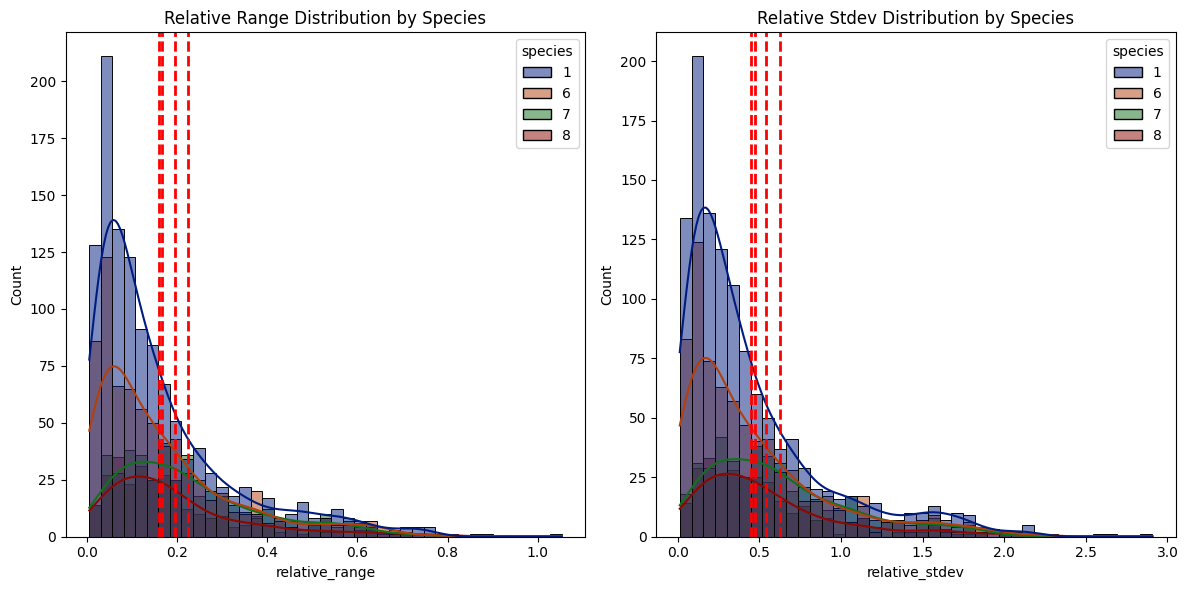

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histograms or density plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=exploded_df, x='relative_range', hue='species', kde=True, palette='dark')
plt.title('Relative Range Distribution by Species')
# Calculate and plot the mean line for 'relative_range'
mean_relative_range = exploded_df.groupby('species')['relative_range'].mean()
for mean in mean_relative_range:
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')



plt.subplot(1, 2, 2)
sns.histplot(data=exploded_df, x='relative_stdev', hue='species', kde=True, palette='dark')
plt.title('Relative Stdev Distribution by Species')
# Calculate and plot the mean line for 'relative_stdev'
mean_relative_stdev = exploded_df.groupby('species')['relative_stdev'].mean()
for mean in mean_relative_stdev:
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')

plt.tight_layout()
plt.show()


In [88]:
filtered_df

,species,coordinates,relative_range,relative_stdev
C10H22N2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.8079, device='cuda:0', grad_fn=<Un...","[0.2812778949737549, 0.47908252477645874, 0.17...","[0.7114307284355164, 1.5271075963974, 0.575314..."
C10H3NO,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-0.9084, device='cuda:0', grad_fn=<U...","[0.24389329552650452, 0.134811669588089, 0.040...","[0.6099414229393005, 0.3811359107494354, 0.114..."
C10H5N,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-6.3169, device='cuda:0', grad_fn=<U...","[0.021898603066802025, 0.1862783133983612, 0.2...","[0.0637490525841713, 0.4981892704963684, 0.645..."
C11H14,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.3402, device='cuda:0', grad_fn=<Un...","[0.05369645729660988, 0.1478632092475891, 0.14...","[0.15190637111663818, 0.45419391989707947, 0.3..."
C11H17N3O6,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.5624, device='cuda:0', grad_fn=<Un...","[0.05875224247574806, 0.5297955870628357, 0.03...","[0.16213743388652802, 1.5366764068603516, 0.09..."
...,...,...,...,...
CH4O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(-1.7581, device='cuda:0', grad_fn=<U...","[0.08544192463159561, 0.08824586123228073, 0.1...","[0.23528477549552917, 0.23359857499599457, 0.3..."
CH5N5O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.2798, device='cuda:0', grad_fn=<Un...","[0.32158032059669495, 0.5602786540985107, 0.33...","[0.8986567258834839, 1.6935776472091675, 1.037..."
CH7N5O2,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.8830, device='cuda:0', grad_fn=<Un...","[0.08764337003231049, 0.3693331778049469, 0.11...","[0.2494133561849594, 1.0652952194213867, 0.265..."
HN3O2,"[[tensor(1, device='cuda:0'), tensor(7, device...","[[[tensor(1.6709, device='cuda:0', grad_fn=<Un...","[0.08424440771341324, 0.0760398581624031, 0.52...","[0.25793373584747314, 0.19284576177597046, 1.6..."


In [90]:
range_df = filtered_df
range_df = range_df['relative_range'].apply(lambda x: [1 if val > 0.5 else 0 for val in x])
range_df

C10H22N2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
C10H3NO           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
C10H5N         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
C11H14        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
C11H17N3O6    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                    ...                        
CH4O3                                  [0, 0, 0, 1, 0, 0, 0, 0]
CH5N5O3              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CH7N5O2           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
HN3O2                                        [0, 0, 1, 1, 0, 0]
N4                                                 [1, 1, 1, 1]
Name: relative_range, Length: 127, dtype: object

In [91]:
stdev_df = filtered_df
stdev_df = stdev_df.drop(columns='relative_range')
stdev_df['relative_stdev'] = stdev_df['relative_stdev'].apply(lambda x: [1 if val > 1.5 else 0 for val in x])

In [92]:
stdev_df

,species,coordinates,relative_stdev
C10H22N2,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(2.8079, device='cuda:0', grad_fn=<Un...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
C10H3NO,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-0.9084, device='cuda:0', grad_fn=<U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
C10H5N,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(-6.3169, device='cuda:0', grad_fn=<U...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
C11H14,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.3402, device='cuda:0', grad_fn=<Un...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
C11H17N3O6,"[[tensor(6, device='cuda:0'), tensor(6, device...","[[[tensor(3.5624, device='cuda:0', grad_fn=<Un...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
CH4O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(-1.7581, device='cuda:0', grad_fn=<U...","[0, 0, 0, 1, 0, 0, 0, 0]"
CH5N5O3,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.2798, device='cuda:0', grad_fn=<Un...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
CH7N5O2,"[[tensor(6, device='cuda:0'), tensor(1, device...","[[[tensor(1.8830, device='cuda:0', grad_fn=<Un...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
HN3O2,"[[tensor(1, device='cuda:0'), tensor(7, device...","[[[tensor(1.6709, device='cuda:0', grad_fn=<Un...","[0, 0, 1, 1, 0, 0]"


In [93]:
def compare_lists(list1, list2):
    return all(x == y for x, y in zip(list1, list2))

comparison_result = stdev_df['relative_stdev'].combine(range_df, compare_lists)

# Count the number of True values (True is treated as 1)
count_true = comparison_result.sum()

# Output the count
print('Total conformers in both dataframes:', len(stdev_df), len(range_df))
print("Number of True values:", count_true)


Total conformers in both dataframes: 127 127
Number of True values: 106


In [94]:
structure = ase.io.read("/home/nick/RSYNC_STUFF/initial.pdb")
numbers = structure.numbers
symbols = np.asarray(structure.symbols).astype(str)
coords = structure.positions.astype(np.float64)
molecule = arrays_to_rdkit_molecule(symbols, coords)

SMILES:  [H]C([H])([H])C([H])([H])OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])OC([H])([H])C([H])([H])C([H])([H])[H]


In [35]:
pwd

'/home/nick'

In [38]:
for formula, row in stdev_df.iterrows():
    species = row['species']
    coord = row['coordinates']
    mol = ase.Atoms(numbers=species.squeeze().tolist(), positions=coord.squeeze().tolist())
    print('Molecule:', mol.symbols)
    bad_atoms = row['relative_stdev']
    pairs = FullPairwise(cutoff=5.2)(species, coord)
    
    neighbor_indices = torch.cat((pairs.indices, pairs.indices.flip(0)), dim=-1).transpose(1, 0)
    _expanded_bad_atom_indices: tp.Set[int] = set()
    print('Bad atom indices:\n', bad_atoms)
    for b in bad_atoms:
        idxs = neighbor_indices[neighbor_indices[:, 0] == b, 1]
        _expanded_bad_atom_indices.update(idxs.tolist())
    bad_atoms = sorted(_expanded_bad_atom_indices)
    print('Size of bad atoms list:\n', len(bad_atoms))
    
    # Internal are bad atoms that are only bonded to other bad atoms
    internal_bad_atom_indices: tp.List[int] = []
    # Leaves are bad atoms that are bonded to one or more non-bad atoms
    leaf_bad_atom_indices: tp.List[int] = []

    molecule = arrays_to_rdkit_molecule(mol.symbols, mol.positions)
    
    atom_list = list(molecule.GetAtoms())
    print(atom_list)
    for idx in bad_atoms:
        atom = atom_list[idx]
        bonds = atom.GetBonds()
        for bond in bonds:
            begin = bond.GetBeginAtomIdx()  # end is self, begin is other
            if begin not in bad_atoms:
                leaf_bad_atom_indices.append(idx)
                break
        else:
            internal_bad_atom_indices.append(idx)
    capped_indices = deepcopy(bad_atoms)
    
    for idx in leaf_bad_atom_indices:
        atom = atom_list[idx]
        bonds = atom.GetBonds()
        for bond in bonds:
            begin = bond.GetBeginAtomIdx()
            if begin not in bad_atoms:
                bond_type = bond.GetBondType()
                if bond_type is not Chem.rdchem.BondType.SINGLE:
                    # Do some work here, there may be things that need to be done
                    pass
#                    raise NotImplementedError("Not implemented yet")
                else:
                    symbols[begin] = "H"
                    capped_indices.append(begin)
    capped_coords = coords[capped_indices]
    capped_symbols = symbols[capped_indices]
    
    capped_structure = ase.Atoms(positions=capped_coords, symbols=capped_symbols)
    ase.io.write(f"capped_{formula}.xyz", capped_structure)          #NOTE: This function can infer file type by the extension, or it can be manually set with format='xyz'/'pdb'/etc

    

Molecule: C10H22N2
Bad atom indices:
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Size of bad atoms list:
 30
SMILES:  [H]/C(=C(/C([H])([H])[H])C([H])([H])N([H])[H])C([H])([H])[H].[H]N([H])[C@]1([H])C([H])([H])C1(C([H])([H])[H])C([H])([H])[H]
[<rdkit.Chem.rdchem.Atom object at 0x7f2f1d4029e0>, <rdkit.Chem.rdchem.Atom object at 0x7f2f1d402970>, <rdkit.Chem.rdchem.Atom object at 0x7f2f1d402c80>, <rdkit.Chem.rdchem.Atom object at 0x7f2f1d402cf0>, <rdkit.Chem.rdchem.Atom object at 0x7f2f1d402d60>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0ac0>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0c80>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0b30>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0ba0>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0f90>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0d60>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0a50>, <rdkit.Chem.rdchem.Atom object at 0x7f2f15df0270>, <rdkit.Chem.rdchem.Atom object at 

IndexError: index 34 is out of bounds for axis 0 with size 34

NameError: name 'numbers' is not defined